## Fitting Eye Model 

In [1]:
# Load necessary packages
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import random
from random import choices
import math
from scipy.optimize import minimize
from stl import mesh
import pandas as pd

## Convert STL File to NPY

In [2]:
# File path to the STL file
stl_file = "Segmentation_Segment_1.stl"
print("Reading from ", stl_file)

# Load the STL file
try:
    stl_data = mesh.Mesh.from_file(stl_file)
except Exception as e:
    print("Error loading STL file:", e)
    exit()

# Print the points data from the STL file
print(stl_data.points)

# Get the points and reshape
points = stl_data.vectors.reshape(-1, 3)
print(points.shape)

# Replace NaN values with zero
points = np.nan_to_num(points)

# Calculate the sum of X, Y, and Z for all vertices
X_sum = np.sum(points[:, 0])
Y_sum = np.sum(points[:, 1])
Z_sum = np.sum(points[:, 2])
print("Sum of X, Y, and Z:", X_sum, Y_sum, Z_sum)

# Save the sum data to a CSV file
csv_file = "eye_point_cloud.csv"
data_df = pd.DataFrame({'X': [X_sum], 'Y': [Y_sum], 'Z': [Z_sum]})
data_df.to_csv(csv_file, index=False)
print("Data saved to", csv_file)

# Save the point cloud as a numpy array
outfile = "eye_point_cloud"
np.save(outfile, points)
print('Point cloud saved to ', outfile + ".npy")


Reading from  Segmentation_Segment_1.stl
[[ 27.519953  -77.513985   -6.813565  ...  27.476166  -77.488075
   -6.8226953]
 [ 27.464668  -77.5671     -6.8025737 ...  27.551147  -77.5562
   -6.8110757]
 [ 29.033447  -77.344604   -7.0241885 ...  28.764454  -77.42495
   -6.979756 ]
 ...
 [ 28.54909   -74.858444   18.497206  ...  28.35077   -75.035934
   18.538244 ]
 [ 28.651487  -75.09655    18.532656  ...  28.35077   -75.035934
   18.538244 ]
 [ 28.789267  -74.90807    18.486612  ...  28.651487  -75.09655
   18.532656 ]]
(202872, 3)
Sum of X, Y, and Z: 5676476.5 -15344114.0 1331001.4
Data saved to eye_point_cloud.csv
Point cloud saved to  eye_point_cloud.npy


# Plot the Eye extract from STL

Loading point cloud from  eye_point_cloud.npy
(202872, 3)
Shape x =  (202872,)
Shape y =  (202872,)
Shape z =  (202872,)


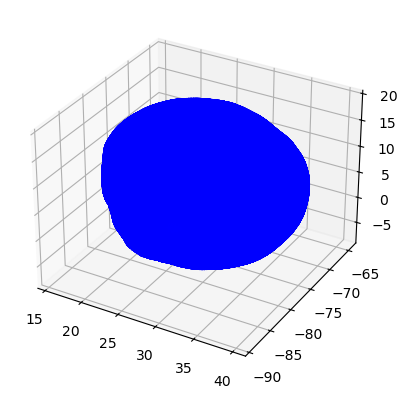

In [3]:
in_file_dir = "eye_point_cloud.npy"
print("Loading point cloud from ", in_file_dir)
with open( in_file_dir , 'rb') as f:
    points = np.load(f)

print(points.shape)

x = points[:,0]
y = points[:,1]
z = points[:,2]
print("Shape x = ", x.shape )
print("Shape y = ", y.shape )
print("Shape z = ", z.shape )

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# subsample pointa
dim = len(x)

xx = []
yy = []
zz = [] 
for i in range(0,dim,1) :
   xx.append(x[i])
   yy.append(y[i])
   zz.append(z[i])

xx = np.array(xx)
yy = np.array(yy)
zz = np.array(zz)

ax.scatter(xx, yy, zz, zdir='z', s=5, c='b', rasterized=True)


## Fit Sphere Model

In [4]:
gamma_guess = np.random.random(4)
gamma_guess[0] = x.mean()
gamma_guess[1] = y.mean()
gamma_guess[2] = z.mean() 

gamma_guess[3] = 5*x.max()

print('Range of x ', x.min() , "to" , x.max() )
print('Range of x ', y.min() , "to" , y.max() )
print('Range of x ', z.min() , "to" , z.max() )

print("Initial guess of parameters")
for gamma_guess_ in gamma_guess :
  print(gamma_guess_)

#
#  Model to fit to the data 
#
def predict(gamma):
    """
     (x-x0)**2/R**2 +  (y-y0)**2/R**2 +  (z-z0)**2/R**2 = 1

    """

    # compute f hat
    x0 = gamma[0]
    y0 = gamma[1]
    z0 = gamma[2]
    R2 = gamma[3]

    zeta0 = x**2 - 2*x*x0 
    zeta1 = y**2 - 2*y*y0
    zeta2 = z**2 - 2*z*z0
    return zeta0 + zeta1 + zeta2 - R2

def loss(g):
    # compute mean squared error
    pred = predict(g)
    mse = np.square(pred).mean()
    return mse

def residual(g,x0,y0,z0):
    # compute mean squared error
    pred = predict(g)
    target = np.ones_like(pred)
    mse = pred-target
    r_store = [] 
    for x_,y_,z_ in zip(x,y,z) :
       r_ = math.sqrt((x_-x0)**2 + (y_-y0)**2 + (z_-z0)**2)  
       r_store.append(r_)

    print("Residual check ", len(r_store), len(mse) )
    print("Max resid = ", max(mse) , "Min resid = " , min(mse) )
    print("Mean resid = " ,  mse.mean() )
    
    return mse,r_store

res = minimize(
    loss,
    gamma_guess,
    args=(),
    )

print("Minimum function ", res)
print("---------------------------------------------")

print("Fit model")
print(predict.__doc__)

#if 0 :
print("Summary fit results")
print(f"FIT, x_0 = {res.x[0]:.2f} mm" )
print(f"FIT, y_0 = {res.x[1]:.2f} mm" )
print(f"FIT, z_0 = {res.x[2]:.2f} mm" )

R_sq = res.x[3] - res.x[0] - res.x[1] - res.x[2] 
if R_sq > 0 :
    R = math.sqrt(R_sq)
    print(f"FIT, R = {R:.2f} mm" )
else:
    print(f"FIT, R**1 = {R_sq:.2f} mm" )


Range of x  15.751336 to 39.876118
Range of x  -89.05725 to -64.73767
Range of x  -7.255441 to 18.723413
Initial guess of parameters
27.980581283569336
-75.63446044921875
6.560793876647949
199.38058853149414
Minimum function    message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 43608500.0
        x: [ 2.798e+01 -7.563e+01  6.561e+00  1.994e+02]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 5
     njev: 1
---------------------------------------------
Fit model

     (x-x0)**2/R**2 +  (y-y0)**2/R**2 +  (z-z0)**2/R**2 = 1

    
Summary fit results
FIT, x_0 = 27.98 mm
FIT, y_0 = -75.63 mm
FIT, z_0 = 6.56 mm
FIT, R = 15.51 mm


## Fit Boot-Non-Linear

In [5]:
noboot = 20


print(points.shape)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]
print("Shape x =", x.shape)
print("Shape y =", y.shape)
print("Shape z =", z.shape)

ndata = len(x)

gamma_guess = np.random.random(6)
gamma_guess[0] = x.mean()
gamma_guess[1] = y.mean()
gamma_guess[2] = z.mean()

gamma_guess[3] = 5.
gamma_guess[4] = 5.
gamma_guess[5] = 5.

print('Range of x ', x.min(), "to", x.max())
print('Range of x ', y.min(), "to", y.max())
print('Range of x ', z.min(), "to", z.max())

print("Initial guess of parameters")
for gamma_guess_ in gamma_guess:
    print(gamma_guess_)

print(" ")


def predict(gamma):
    """
     (x-x0)**2/a**2 +  (y-y0)**2/b**2 +  (z-z0)**2/c**2 = 1
    """
    x0, y0, z0, a2, b2, c2 = gamma
    zeta0 = (x - x0) ** 2 / a2
    zeta1 = (y - y0) ** 2 / b2
    zeta2 = (z - z0) ** 2 / c2
    return zeta0 + zeta1 + zeta2


def loss(g):
    # compute mean squared error
    pred = predict(g)
    target = np.ones_like(pred)
    mse = np.square(pred - target).mean()
    return mse


print(loss(gamma_guess))

res = minimize(
    loss,
    gamma_guess,
    jac=False,
    method='BFGS',
    tol=1e-17,
    options={'disp': True}
)

print("MSE =", res.fun)
print("Function evaluations =", res.nfev)
print("Gradient evaluations =", res.njev)

print("Fit model")
print(predict.__doc__)

print("Summary fit results")
print(f"FIT, x_0 = {res.x[0]:.2f} mm")
print(f"FIT, y_0 = {res.x[1]:.2f} mm")
print(f"FIT, z_0 = {res.x[2]:.2f} mm")
print(f"FIT, a = {res.x[3]:.1f} mm")
print(f"FIT, b = {res.x[4]:.1f} mm")
print(f"FIT, c = {res.x[5]:.1f} mm")

print("Starting the bootstrap analysis")

a_sample = []
b_sample = []
c_sample = []

for iboot in range(0, noboot):
    print("Working on bootstrap sample", iboot)

    # Create the bootstrap sample
    i_sample = np.random.choice(ndata, ndata, replace=True)
    xb = x[i_sample]
    yb = y[i_sample]
    zb = z[i_sample]

    resB = minimize(
        loss,
        gamma_guess,
        jac=False,
        method='BFGS',
        tol=1e-17,
        options={'disp': False}
    )

    a_sample.append(resB.x[3])
    b_sample.append(resB.x[4])
    c_sample.append(resB.x[5])

err_a = np.std(np.array(a_sample))
err_b = np.std(np.array(b_sample))
err_c = np.std(np.array(c_sample))

print(f"FIT, a = {res.x[3]:.3f} +/- {err_a:.3f} mm")
print(f"FIT, b = {res.x[4]:.3f} +/- {err_b:.3f} mm")
print(f"FIT, c = {res.x[5]:.3f} +/- {err_c:.3f} mm")

(202872, 3)
Shape x = (202872,)
Shape y = (202872,)
Shape z = (202872,)
Range of x  15.751336 to 39.876118
Range of x  -89.05725 to -64.73767
Range of x  -7.255441 to 18.723413
Initial guess of parameters
27.980581283569336
-75.63446044921875
6.560793876647949
5.0
5.0
5.0
 
781.0542
Optimization terminated successfully.
         Current function value: 781.054199
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1
MSE = 781.0542
Function evaluations = 7
Gradient evaluations = 1
Fit model

     (x-x0)**2/a**2 +  (y-y0)**2/b**2 +  (z-z0)**2/c**2 = 1
    
Summary fit results
FIT, x_0 = 27.98 mm
FIT, y_0 = -75.63 mm
FIT, z_0 = 6.56 mm
FIT, a = 5.0 mm
FIT, b = 5.0 mm
FIT, c = 5.0 mm
Starting the bootstrap analysis
Working on bootstrap sample 0
Working on bootstrap sample 1
Working on bootstrap sample 2
Working on bootstrap sample 3
Working on bootstrap sample 4
Working on bootstrap sample 5
Working on bootstrap sample 6
Working on bootstrap sample 7
Work

## Non-Linear

Initial guess of parameters
27.980581283569336
-75.63446044921875
6.560793876647949
12.06239128112793
12.1597900390625
12.98942756652832
Initial Loss: 1.186562
Optimization terminated successfully.
         Current function value: 1.186562
         Iterations: 0
         Function evaluations: 7
         Gradient evaluations: 1
MSE = 1.186562
Optimal Parameters:
x_0 = 27.98 mm
y_0 = -75.63 mm
z_0 = 6.56 mm
a = 12.1 mm
b = 12.2 mm
c = 13.0 mm


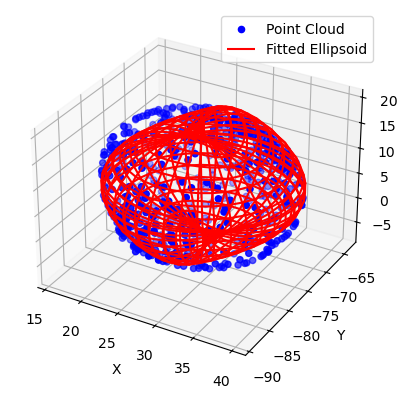

In [6]:
# Extract the x, y, and z coordinates from the point cloud
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Calculate the initial values for a, b, and c based on the data
initial_a = (x.max() - x.min()) / 2.00
initial_b = (y.max() - y.min()) / 2.00
initial_c = (z.max() - z.min()) / 2.00

# Modify the initial guess for the ellipsoid parameters
gamma_guess = np.random.random(6)
gamma_guess[0] = x.mean()
gamma_guess[1] = y.mean()
gamma_guess[2] = z.mean()
gamma_guess[3] = initial_a
gamma_guess[4] = initial_b
gamma_guess[5] = initial_c


print("Initial guess of parameters")
for gamma_guess_ in gamma_guess:
    print(gamma_guess_)

# Define the ellipsoid equation
def predict(gamma):
    x0, y0, z0, a2, b2, c2 = gamma
    zeta0 =((x - x0)** 2) / a2**2
    zeta1 =((y - y0)** 2 )/ b2**2
    zeta2 = ((z - z0)** 2) / c2**2
    return zeta0 + zeta1 + zeta2 - 1

# Define the loss function (mean squared error)
def loss(g):
    pred = predict(g)
    target = np.ones_like(pred)
    mse = np.square(pred - target).mean()
    return mse

# Print the initial loss
print("Initial Loss:", loss(gamma_guess))

# Minimize the loss function to fit the ellipsoid
res = minimize(
    loss,
    gamma_guess,
    jac=False,
    method='BFGS',
    tol=1e-17,
    options={'disp': True}
)

# Print the optimization results
print("MSE =", res.fun)
print("Optimal Parameters:")
print(f"x_0 = {res.x[0]:.2f} mm")
print(f"y_0 = {res.x[1]:.2f} mm")
print(f"z_0 = {res.x[2]:.2f} mm")
print(f"a = {res.x[3]:.1f} mm")
print(f"b = {res.x[4]:.1f} mm")
print(f"c = {res.x[5]:.1f} mm")

# Plot the fitted ellipsoid and a subsampled point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Subsample the point cloud for better visualization
subsample_step = 300
ax.scatter(x[::subsample_step], y[::subsample_step], z[::subsample_step], s=20, c='b', label='Point Cloud')

# Plot the fitted ellipsoid
u, v = np.meshgrid(np.linspace(0, 2 * np.pi, 40), np.linspace(0, np.pi, 20))
r = 1.0 / np.sqrt((np.cos(u) / res.x[3]) ** 2 + ((np.sin(u) / res.x[4]) ** 2) * (np.sin(v) ** 2) + ((np.cos(v) / res.x[5]) ** 2))
x_fit = res.x[0] + np.cos(u) * np.sin(v) * r
y_fit = res.x[1] + np.sin(u) * np.sin(v) * r
z_fit = res.x[2] + np.cos(v) * r

ax.plot_wireframe(x_fit, y_fit, z_fit, color="r", label='Fitted Ellipsoid')

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

# Save the 3D plot as an image
plt.savefig('eyeFIT.png', format='png', dpi=300, bbox_inches='tight')

# Show the 3D plot
plt.show()